In [1]:
# once i have wholegenome_offset.trees
import pandas as pd
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pandas as pd
import glob
from matplotlib import colors as mcolors
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm 

/tmp/ipykernel_2595863/1515799442.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def get_params(df):
    df = df.reset_index()
    df['index'] = df['index'].str.split('/subp').str[0]
    df['optima'] = df['index'].str.split('/').str[-1]
    df['sel'] = df['index'].str.split('/').str[-2]
    df['h2'] = df['index'].str.split('/').str[-3]
    df['poly'] = df['index'].str.split('_').str[-2]
    df['rep'] = df['index'].str.split('_').str[-1].str.split('/').str[0]
    df = df.drop('index',axis=1)
    return df

In [3]:
#savio
path = '/global/scratch/users/tbellg/slim_grenenet_results/final_results_cteg_talk/scrapping_results/es_dep_af/'

In [4]:
path = '/home/tbellagio/simulations/slim_grenenet_results/final_results_cteg_talk/scrapping_results/es_dep_af/'

In [5]:
heritability_data= {'1': 0.1,
'2': 0.3,
'3': 0.5,
'4': 0.7,
'5': 0.9}

optima_dict = {'optima7': 7,
                'optima6': 6,
               'optima5': 5,
               'optima4': 4,
               'optima3': 3,
               'optima2': 2,
               'optima1.5': 1.5,
               'optima1': 1,
               'optima0': 0}

def get_params(df):
    df = df.reset_index()
    df['index'] = df['index'].str.split('/subp').str[0]
    df['optima'] = df['index'].str.split('/').str[-1]
    df['sel'] = df['index'].str.split('/').str[-2]
    df['h2'] = df['index'].str.split('/').str[-3]
    df['poly'] = df['index'].str.split('_').str[-2]
    df['rep'] = df['index'].str.split('_').str[-1].str.split('/').str[0]
    df = df.drop('index',axis=1)
    return df

In [6]:
def process_metric(metric_name):
    v_fitness = pd.read_csv(path + metric_name + '.csv',  index_col=[0])

    v_fitness = v_fitness.reset_index()

    v_fitness = get_params(v_fitness)


    v_fitness['poly'] = v_fitness['poly'].str.replace('pi', '').astype(int)
    v_fitness.loc[:, 'h2'] = v_fitness['h2'].replace(heritability_data)
    v_fitness.loc[:, 'optima'] = v_fitness['optima'].replace(optima_dict)
    return v_fitness

In [7]:
def plot_metric(metric_name, y_lim_min, y_lim_max, optima_list, replace_0):
    v_fitness = pd.read_csv(path + metric_name + '.csv',  index_col=[0])

    v_fitness = v_fitness.reset_index()

    v_fitness = get_params(v_fitness)


    v_fitness['poly'] = v_fitness['poly'].str.replace('pi', '').astype(int)
    v_fitness.loc[:, 'h2'] = v_fitness['h2'].replace(heritability_data)
    v_fitness.loc[:, 'optima'] = v_fitness['optima'].replace(optima_dict)

    df = v_fitness.copy()

    h2_levels = sorted(df['h2'].unique())#heritability_data.values()
    optima_levels = optima_list
    poly_levels = sorted(df['poly'].unique())#poligenicity_data.values()
    poly_levels_colors = sns.color_palette("viridis", n_colors=len(poly_levels))

    if replace_0: 
        df = df.fillna(0)

    fig, axs = plt.subplots(len(h2_levels), len(optima_levels), figsize=(20, 10), sharex=True)

    # Handling the 1D array case for axs
    if len(h2_levels) == 1:
        axs = np.array([axs])
    if len(optima_levels) == 1:
        axs = np.array([axs]).T

    for i, h2 in enumerate(h2_levels):
        for j, optima in enumerate(optima_levels):
            ax = axs[i, j] if len(h2_levels) > 1 and len(optima_levels) > 1 else axs[max(i, j)]
            subset_df = df[df['h2'] == h2]

            for poly,color in zip(poly_levels, poly_levels_colors):
                poly_subset = subset_df[(subset_df['optima'] == optima) & (subset_df['poly'] == poly)]
                generations = list(map(str, range(10)))

                # Calculate mean and SEM (Standard Error of the Mean) for each generation
                means = poly_subset[generations].mean()
                sems = poly_subset[generations].sem()

                # Calculate the confidence intervals
                ci = 1.96 * sems  # 95% confidence interval, adjust the multiplier as needed for different confidence levels

                # Plotting the mean population size per generation
                ax.plot(generations, means, label=f'Poly {poly}', color = color)

                # Adding the confidence interval as a shaded area
                ax.fill_between(generations, (means - ci), (means + ci), alpha=0.2, color = color)
                # Markers for zero values
                zero_indices = means[means == 0].index
                if not zero_indices.empty:
                    ax.scatter(zero_indices, [0]*len(zero_indices), color=color, zorder=9, alpha=0.5)
                
            #ax.axhline(0, color='grey', linestyle='-', linewidth=1)
            #ax.axvline(0, color='grey', linestyle='-', linewidth=1)

            #ax.set_ylim(y_lim_min, y_lim_max)  # Adjust 100 to your desired maximum y-value
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_color('grey')
            ax.spines['left'].set_color('grey')
            ax.set_title(f'H2: {h2}, Optima: {optima}')
            ax.set_xlabel('Generation')
            ax.set_ylabel(metric_name)
            if i == len(h2_levels) - 1 and j == 0:
                ax.legend(title='Polygenicity')

    plt.tight_layout()
    return plt.show()

In [8]:
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.lines import Line2D

# Save legend separately
def save_legend(legend_handles, labels, filename='legend.pdf', title='Polygenicity'):
    fig_legend = plt.figure(figsize=(2.5, len(labels) * 0.3 + 0.5))  # adjust size as needed
    ax = fig_legend.add_subplot(111)
    ax.axis('off')  # Hide axes

    legend = ax.legend(
        handles=legend_handles,
        labels=labels,
        title=title,
        loc='center',
        frameon=False
    )

    with PdfPages(filename) as pdf:
        pdf.savefig(fig_legend, bbox_inches='tight')

    plt.close(fig_legend)


In [20]:
def plot_metric(metric_name, replace_0, heritability, y_lims=None):
    v_fitness = pd.read_csv(path + metric_name + '.csv', index_col=[0])
    v_fitness = v_fitness.reset_index()
    v_fitness = get_params(v_fitness)

    v_fitness['poly'] = v_fitness['poly'].str.replace('pi', '').astype(int)
    v_fitness.loc[:, 'h2'] = v_fitness['h2'].replace(heritability_data)
    v_fitness.loc[:, 'optima'] = v_fitness['optima'].replace(optima_dict)

    df = v_fitness.copy()

    # Only keep rows with the desired heritability
    df = df[df['h2'] == heritability]
    h2_levels = [heritability]  # now only one level

    optima_levels = [1, 2, 3, 4, 5, 6,7]
    poly_levels = sorted(df['poly'].unique())
    poly_levels_colors = sns.color_palette("viridis", n_colors=len(poly_levels))

    if replace_0:
        df = df.fillna(0)

    fig, axs = plt.subplots(1, len(optima_levels), figsize=(32, 5), sharex=True)

    # Force axs to always be 2D for consistent indexing
    axs = np.atleast_2d(axs)

    legend_handles = []  # Store handles for one legend
    for j, optima in enumerate(optima_levels):
        ax = axs[0, j]
        subset_df = df[df['optima'] == optima]

        for poly, color in zip(poly_levels, poly_levels_colors):
            poly_subset = subset_df[subset_df['poly'] == poly]
            generations = list(map(str, range(10)))
            means = poly_subset[generations].mean()
            sems = poly_subset[generations].sem()
            ci = 1.96 * sems

            line, = ax.plot(generations, means, label=f'Poly {poly}', color=color)
            ax.fill_between(generations, (means - ci), (means + ci), alpha=0.2, color=color)
            zero_indices = means[means == 0].index
            if not zero_indices.empty:
                ax.scatter(zero_indices, [0] * len(zero_indices), color=color, zorder=9, alpha=0.5)

            # Only collect legend handles once
            if j == 0:
                legend_handles.append(line)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_color('grey')
        ax.spines['left'].set_color('grey')
        ax.set_title(f'h2: {heritability}, Optima: {optima}')
        ax.set_xlabel('Generation')
        ax.set_ylabel(metric_name)
        if y_lims and optima in y_lims:
            ax.set_ylim(*y_lims[optima])

    # Add external legend without shrinking plots
    fig.legend(handles=legend_handles, labels=[f'Poly {p}' for p in poly_levels],
               title='Polygenicity', loc='center left', bbox_to_anchor=(1.01, 0.5))

    plt.tight_layout()
    plt.savefig('pop_size_over_time_h207.pdf')
    plt.savefig('pop_size_over_time_h207.png')


    save_legend(
    legend_handles,
    labels=[f'Poly {p}' for p in poly_levels],
    filename='legend_polygenicity.pdf.pdf'
    )
    
    return plt.show()


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D

def plot_metric_mlines(metric_name, replace_0, heritability, y_lim_min=None, y_lim_max=None):
    # Load and preprocess
    v_fitness = pd.read_csv(path + metric_name + '.csv', index_col=[0])
    v_fitness = v_fitness.reset_index()
    v_fitness = get_params(v_fitness)

    v_fitness['poly'] = v_fitness['poly'].str.replace('pi', '').astype(int)
    v_fitness['h2'] = v_fitness['h2'].replace(heritability_data)
    v_fitness['optima'] = v_fitness['optima'].replace(optima_dict)

    df = v_fitness.copy()
    df = df[df['h2'] == heritability]  # Only keep selected h2

    optima_levels = [1, 2, 3, 4, 5, 6,7]
    poly_levels = sorted(df['poly'].unique())
    poly_levels_colors = sns.color_palette("viridis", n_colors=len(poly_levels))
    generations = list(map(str, range(10)))

    if replace_0:
        df = df.fillna(0)

    # Set up subplots
    fig, axs = plt.subplots(1, len(optima_levels), figsize=(32, 5), sharex=True)
    axs = np.atleast_2d(axs)

    # Prepare legend handles
    legend_handles = []

    for j, optima in enumerate(optima_levels):
        ax = axs[0, j]
        subset_df = df[df['optima'] == optima]

        for poly, color in zip(poly_levels, poly_levels_colors):
            poly_subset = subset_df[subset_df['poly'] == poly]

            # Plot each replicate as a separate line
            for idx, row in poly_subset.iterrows():
                values = row[generations].values
                ax.plot(generations, values, color=color, alpha=0.4, linewidth=1)

            # Dummy line for legend
            if j == 0:
                dummy_line = Line2D([], [], color=color, label=f'Poly {poly}', linewidth=2)
                legend_handles.append(dummy_line)

        ax.set_title(f'h2: {heritability}, Optima: {optima}')
        ax.set_xlabel('Generation')
        ax.set_ylabel(metric_name)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_color('grey')
        ax.spines['left'].set_color('grey')
        if y_lim_min is not None and y_lim_max is not None:
            ax.set_ylim(y_lim_min, y_lim_max)

    # Add external legend
    fig.legend(handles=legend_handles, title='Polygenicity',
               loc='center left', bbox_to_anchor=(1.01, 0.5))
    plt.tight_layout()
    return plt.show()


In [11]:
os.listdir(path)

['vpheno.csv',
 'minphenotype.csv',
 'pop_size_early.csv',
 'mfitnes.csv',
 'mpheno.csv',
 '.ipynb_checkpoints',
 'maxphenotype.csv',
 'va_ve.csv',
 'vfitnes.csv']

In [12]:
pop_size = pd.read_csv(path + 'pop_size_early.csv',  index_col=[0])

pop_size = get_params(pop_size)

In [13]:
#survival_col = pop_size['9'].isna().replace({True: 0, False: 1})
#pop_size['survival']= survival_col

In [14]:
#survival = pop_size[['optima', 'sel', 'h2', 'poly', 'rep', 'survival']]

In [15]:
pop_size

Unnamed: 1       0       1      2      3      4      5      6     7  \
0               0  2310.0     NaN    NaN    NaN    NaN    NaN    NaN   NaN   
1               0  2310.0     NaN    NaN    NaN    NaN    NaN    NaN   NaN   
2               0  2310.0     NaN    NaN    NaN    NaN    NaN    NaN   NaN   
3               0  2310.0     NaN    NaN    NaN    NaN    NaN    NaN   NaN   
4               0  2310.0     NaN    NaN    NaN    NaN    NaN    NaN   NaN   
...           ...     ...     ...    ...    ...    ...    ...    ...   ...   
48595           0  2310.0  1112.0  675.0  433.0  263.0  200.0  153.0  98.0   
48596           0  2310.0  1181.0  847.0  484.0  254.0  265.0  173.0  97.0   
48597           0  2310.0  1266.0  829.0  547.0  330.0  241.0  143.0  55.0   
48598           0  2310.0  1268.0  817.0  491.0  247.0  158.0   82.0  94.0   
48599           0  2310.0  1431.0  999.0  652.0  479.0  343.0  146.0  92.0   

          8     9   optima         sel h2   poly rep  
0       NaN   NaN  optima2  estrongsel  5    pi2  11  
1       NaN   NaN  optima2  estrongsel  5    pi2  11  
2       NaN   NaN  optima2  estrongsel  5    pi2  11  
3       NaN   NaN  optima2  estrongsel  5    pi2  11  
4       NaN   NaN  optima2  estrongsel  5    pi2  11  
...     ...   ...      ...         ... ..    ...  ..  
48595  50.0  65.0  optima0  estrongsel  3  pi500  23  
48596  42.0  43.0  optima0  estrongsel  3  pi500  23  
48597  33.0  16.0  optima0  estrongsel  3  pi500  23  
48598  46.0  40.0  optima0  estrongsel  3  pi500  23  
48599  33.0  41.0  optima0  estrongsel  3  pi500  23  

[48600 rows x 16 columns]

In [16]:
close_optima = ['optima1', 'optima1.5', 'optima2', 'optima3']
far_optima = ['optima4', 'optima5', 'optima6']

close_optima = [1,1.5,2,3]
far_optima = [4,5,6]


In [17]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42 

/tmp/ipykernel_2595863/854624807.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  v_fitness.loc[:, 'h2'] = v_fitness['h2'].replace(heritability_data)
/tmp/ipykernel_2595863/854624807.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  v_fitness.loc[:, 'optima'] = v_fitness['optima'].replace(optima_dict)


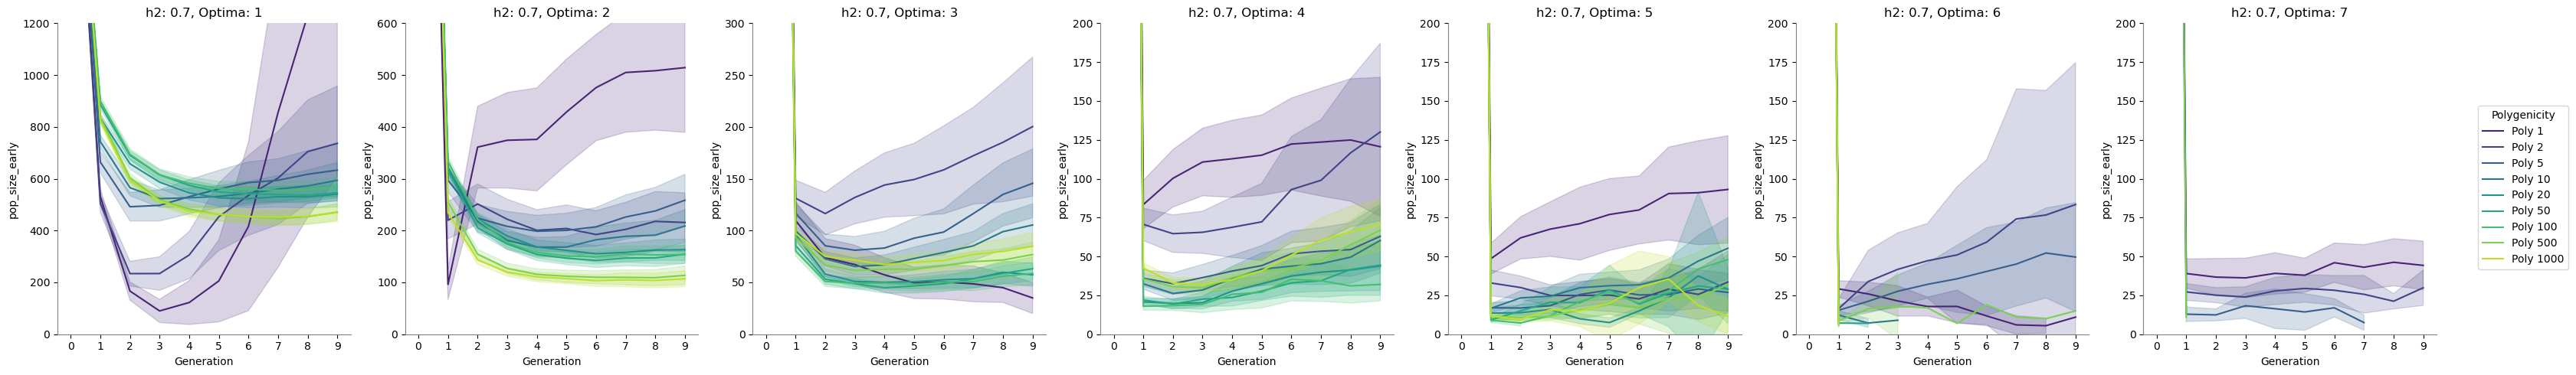

In [23]:
plot_metric(
    'pop_size_early',
    replace_0=False,
    heritability=0.7,
    y_lims={1: (0, 1200), 2: (0, 600), 3: (0, 300), 4: (0, 200), 5: (0, 200), 6: (0, 200), 7: (0, 200)}
)

/tmp/ipykernel_1676367/3156382087.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  v_fitness.loc[:, 'h2'] = v_fitness['h2'].replace(heritability_data)


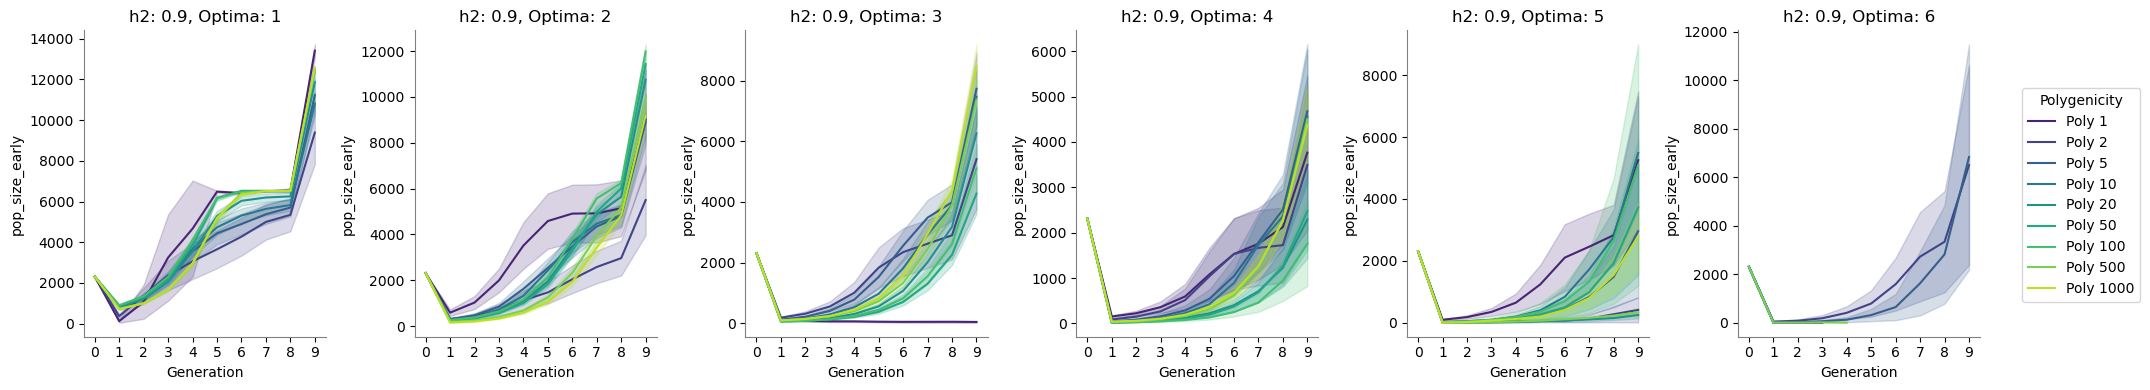

In [66]:
plot_metric('pop_size_early', False, 0.9)

/tmp/ipykernel_1676367/3156382087.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  v_fitness.loc[:, 'h2'] = v_fitness['h2'].replace(heritability_data)


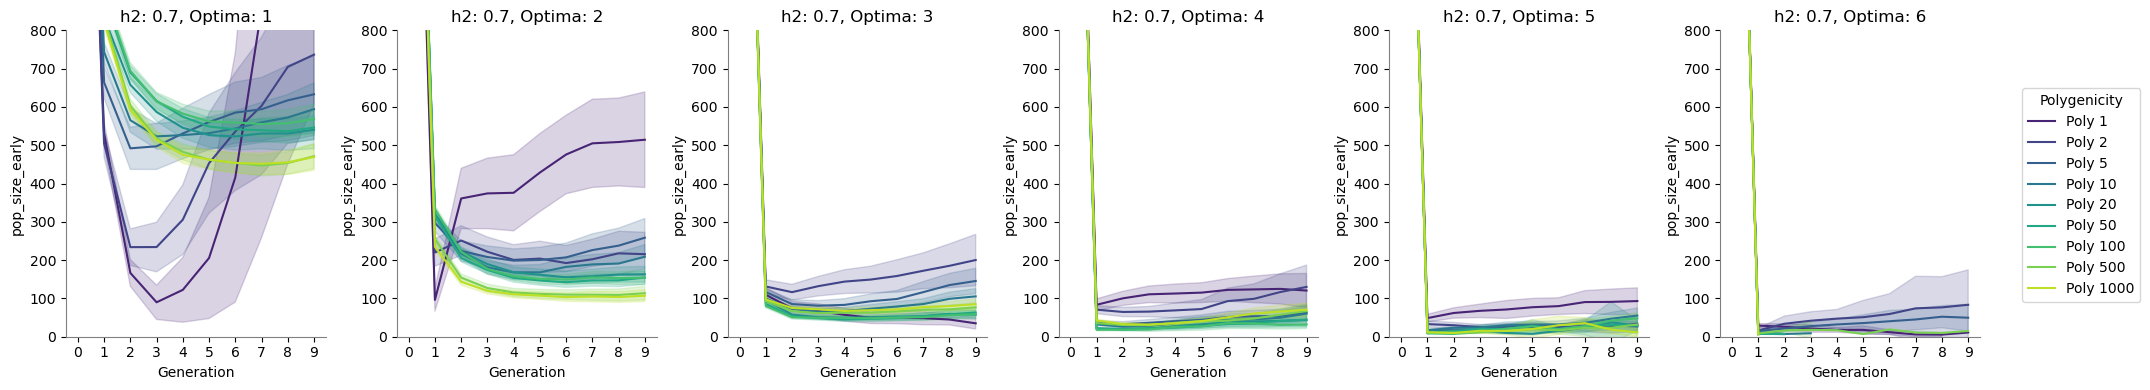

In [67]:
plot_metric('pop_size_early', False, 0.7, y_lim_min=0, y_lim_max=800)

/tmp/ipykernel_1676367/3600277611.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  v_fitness['h2'] = v_fitness['h2'].replace(heritability_data)


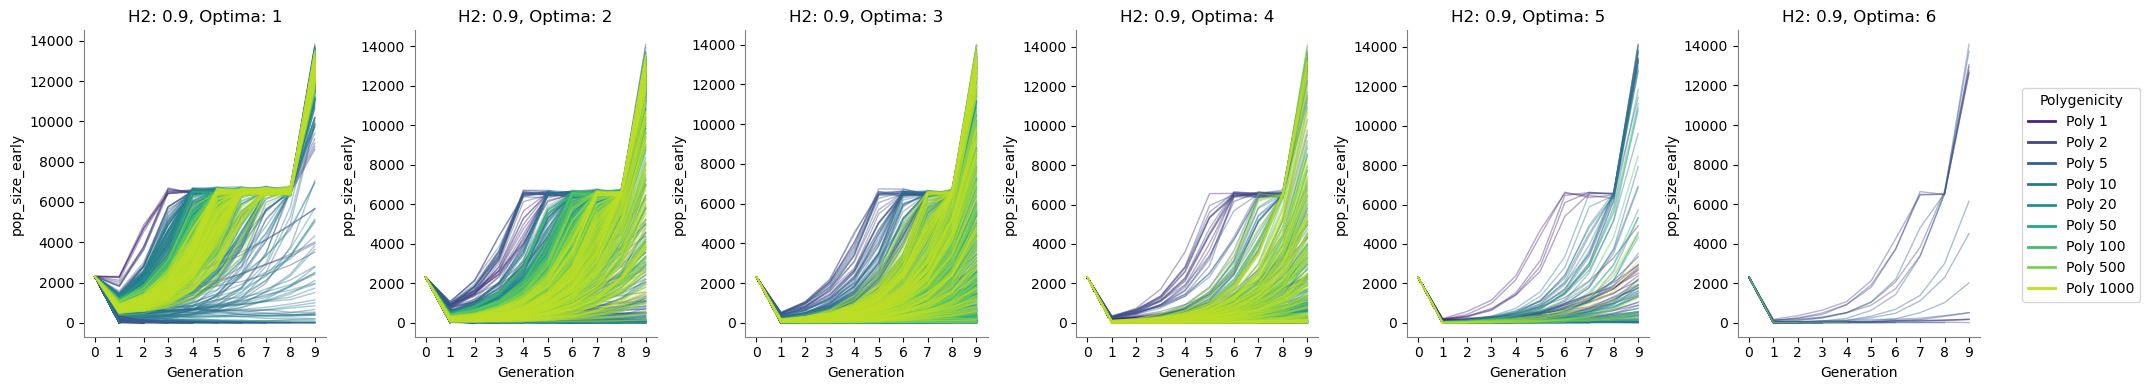

In [62]:
plot_metric('pop_size_early', False, 0.9)

/tmp/ipykernel_1676367/3600277611.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  v_fitness['h2'] = v_fitness['h2'].replace(heritability_data)


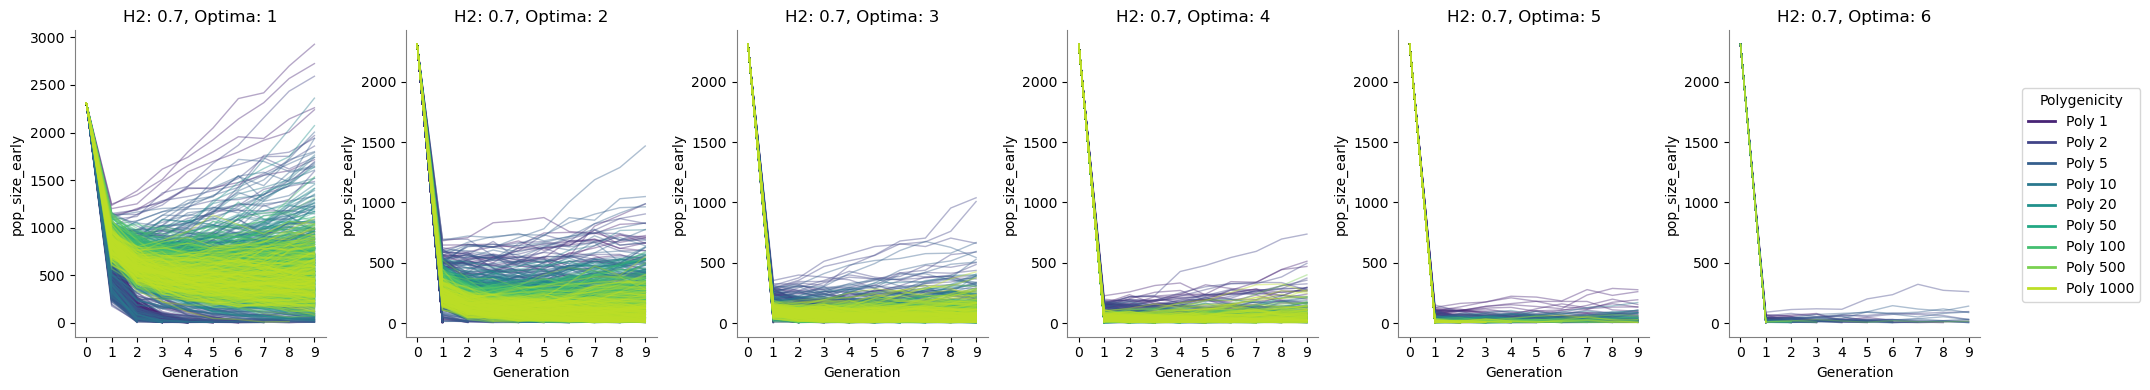

In [63]:
plot_metric('pop_size_early', False, 0.7)

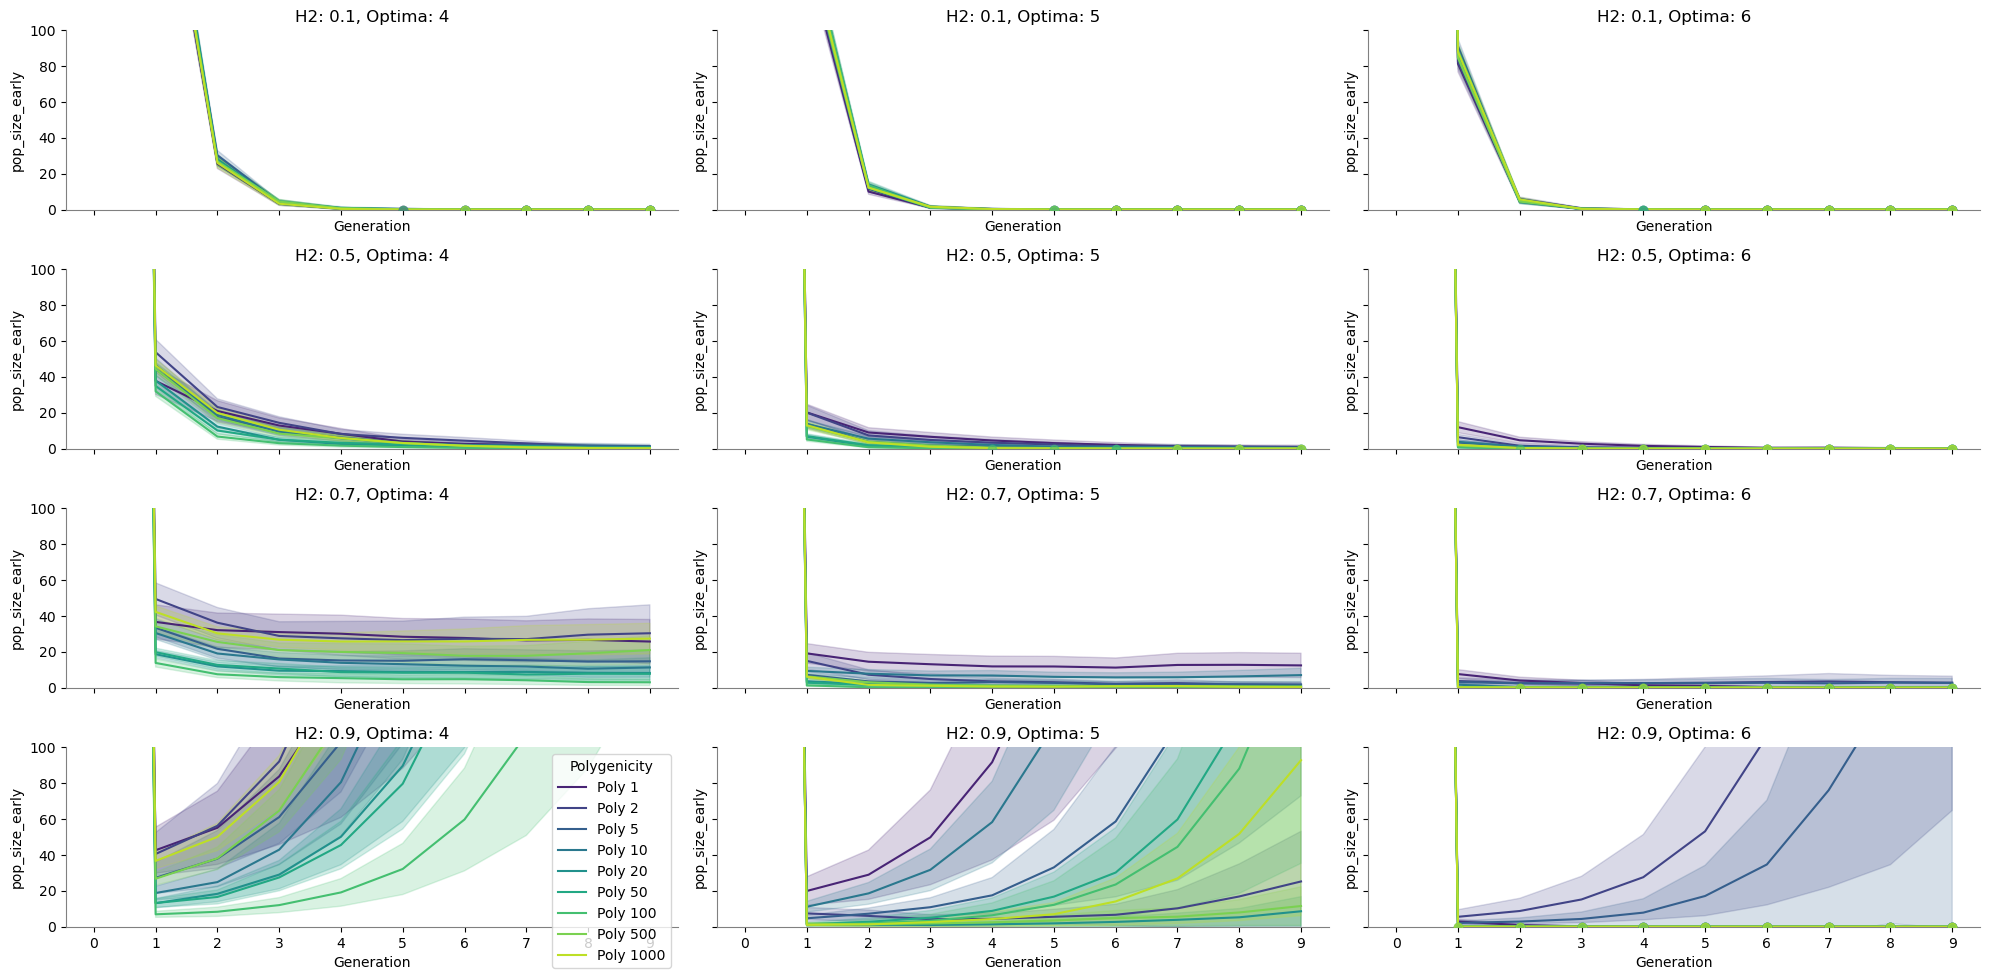

In [12]:
plot_metric('pop_size_early',0, 100, far_optima)

In [15]:
os.listdir(path)

['maxphenotype.csv',
 'mpheno.csv',
 '.ipynb_checkpoints',
 'vfitnes.csv',
 'va_ve.csv',
 'pop_size_early.csv',
 'vpheno.csv',
 'minphenotype.csv',
 'mfitnes.csv']

In [19]:
mpheno = pd.read_csv(path + 'mpheno' + '.csv',  index_col=[0])


In [25]:
mpheno = process_metric('mpheno')

In [29]:
optima6_mpheno = mpheno[mpheno['optima']==6]

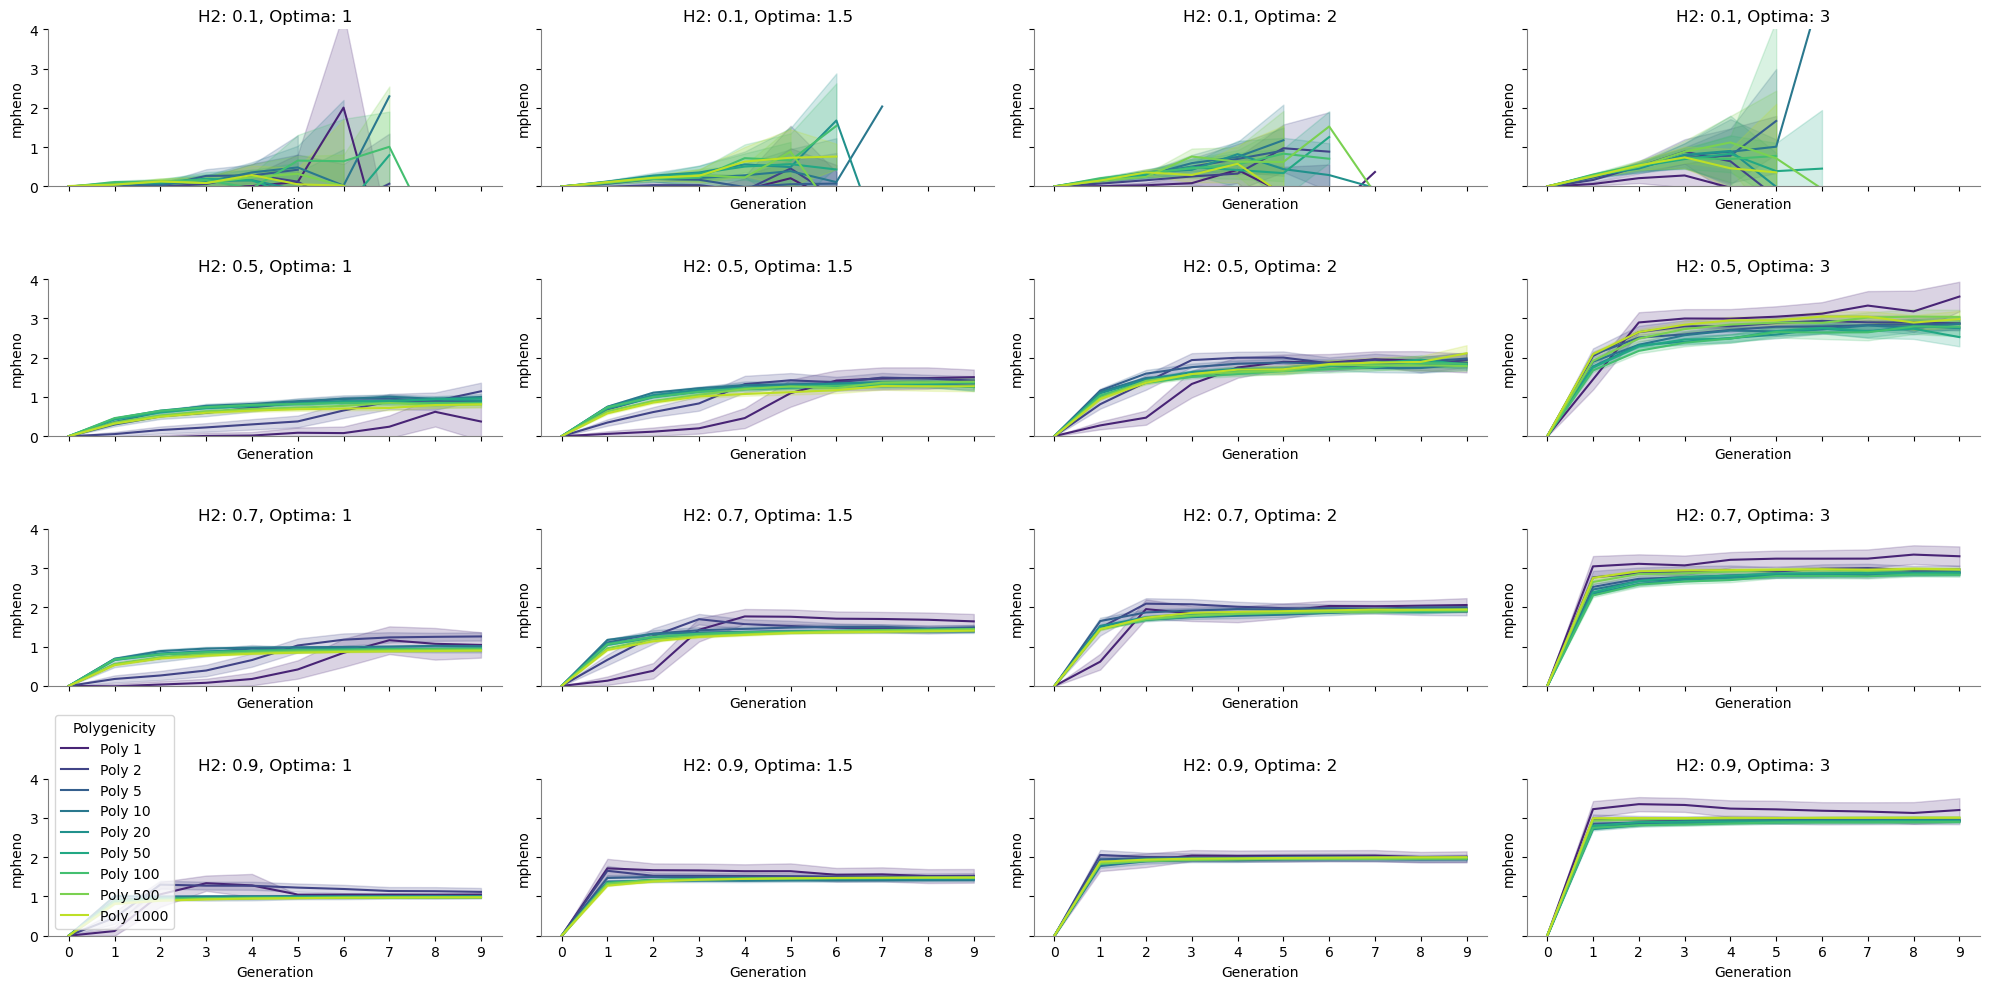

In [35]:
plot_metric('mpheno',0, 4, close_optima, False)

In [36]:
plot_metric('mpheno',0, 6.5, far_optima, False)

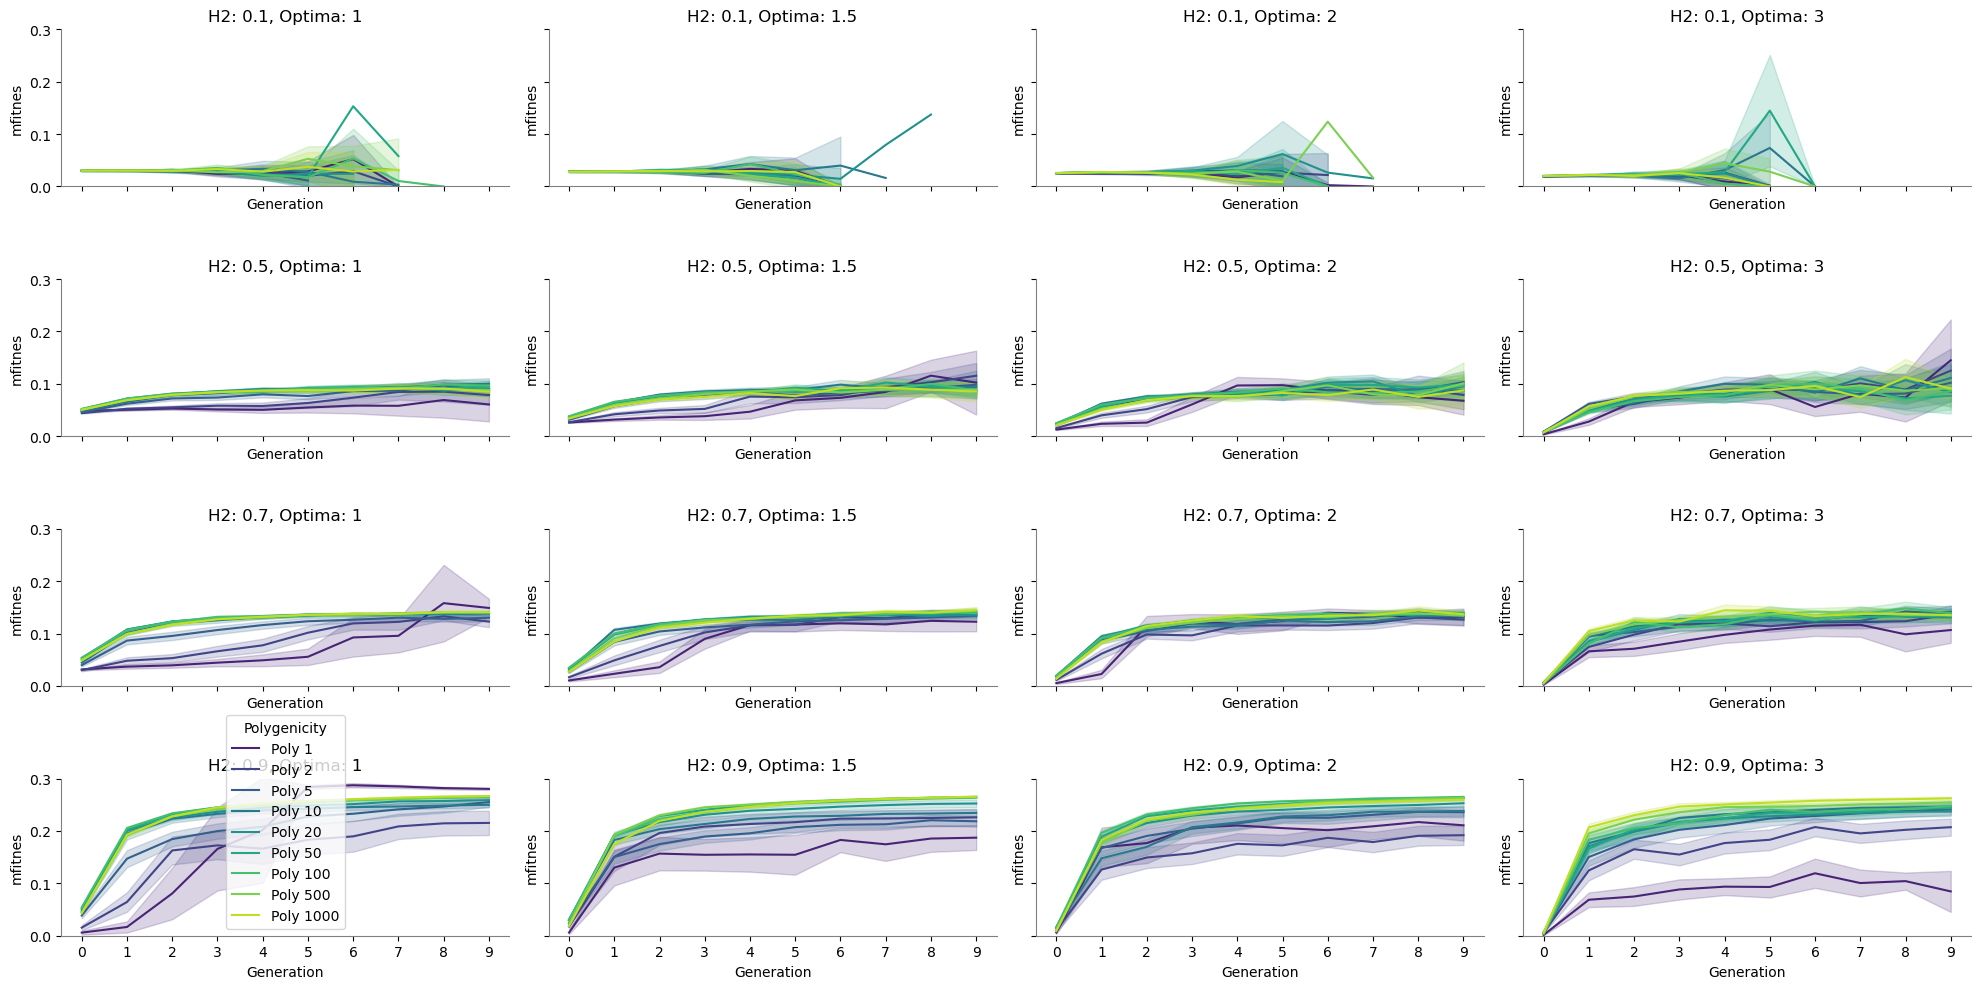

In [41]:
plot_metric('mfitnes',0, 0.3, close_optima, False)

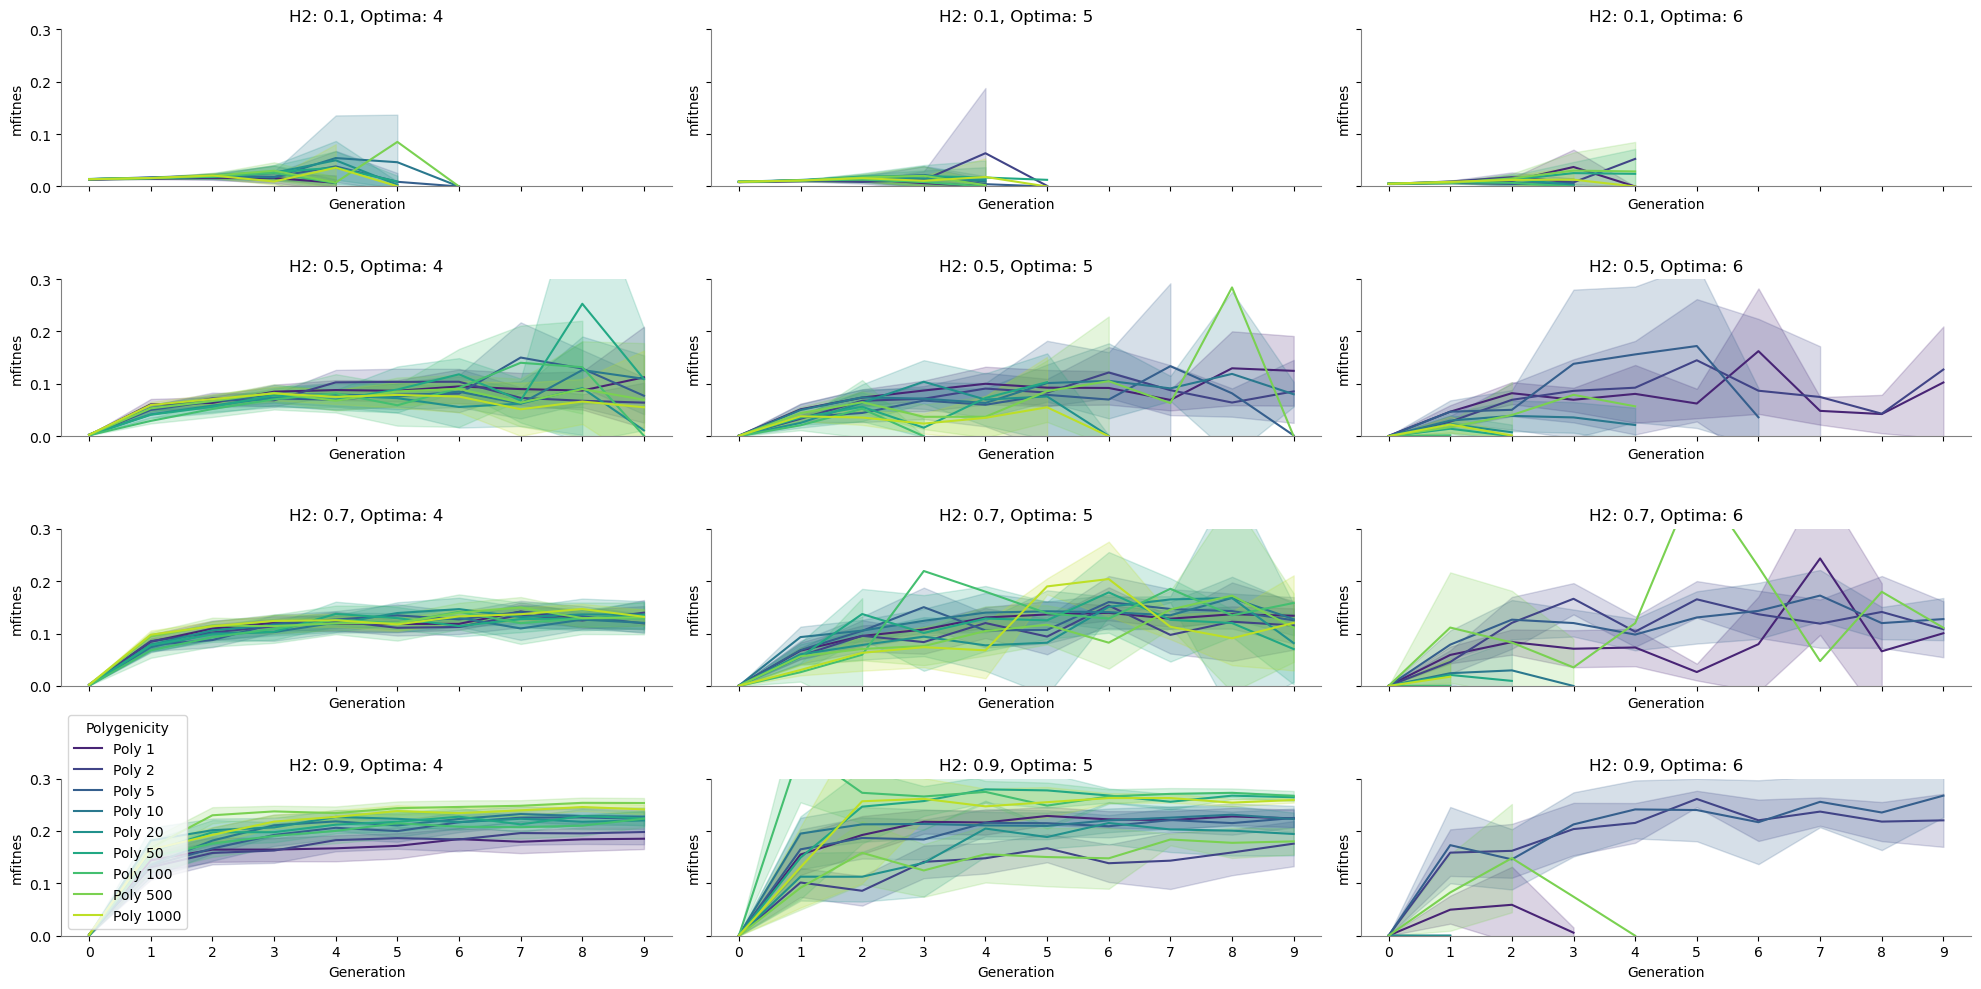

In [42]:
plot_metric('mfitnes',0, 0.3, far_optima, False)

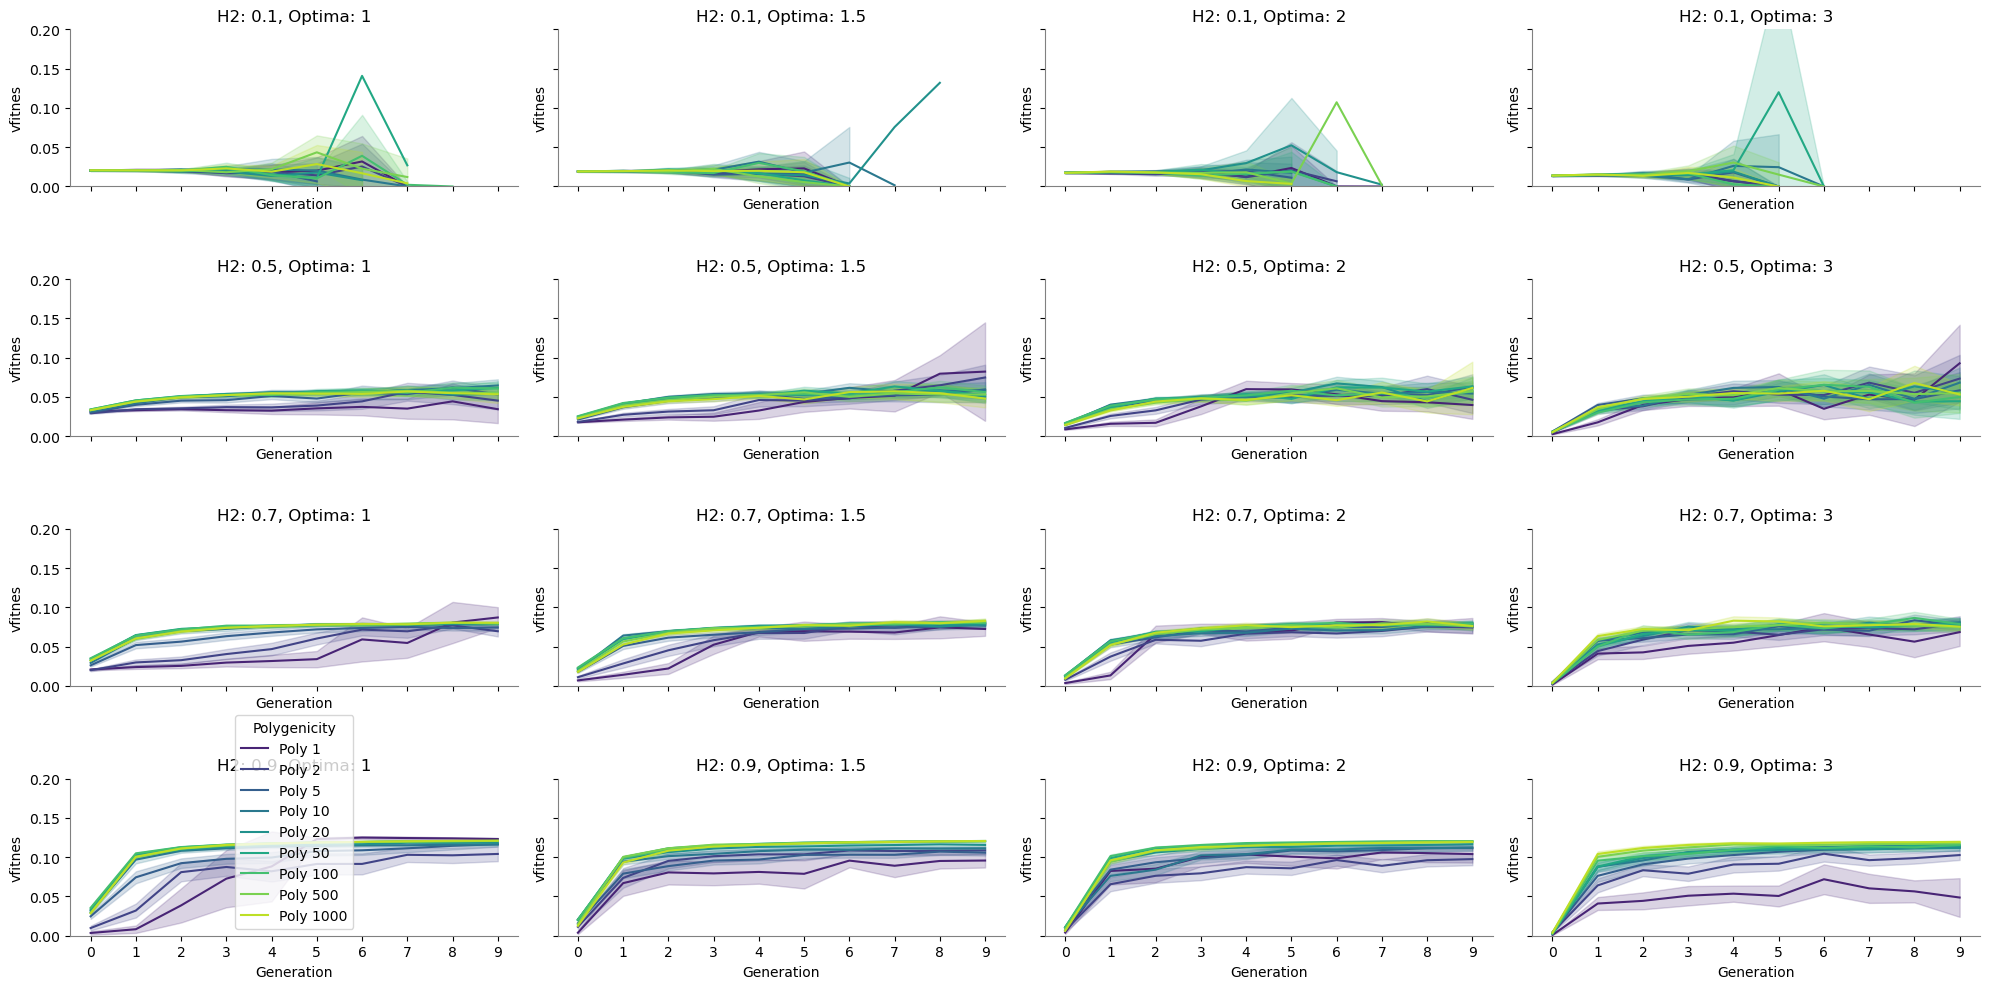

In [45]:
plot_metric('vfitnes',0, 0.2, close_optima, False)

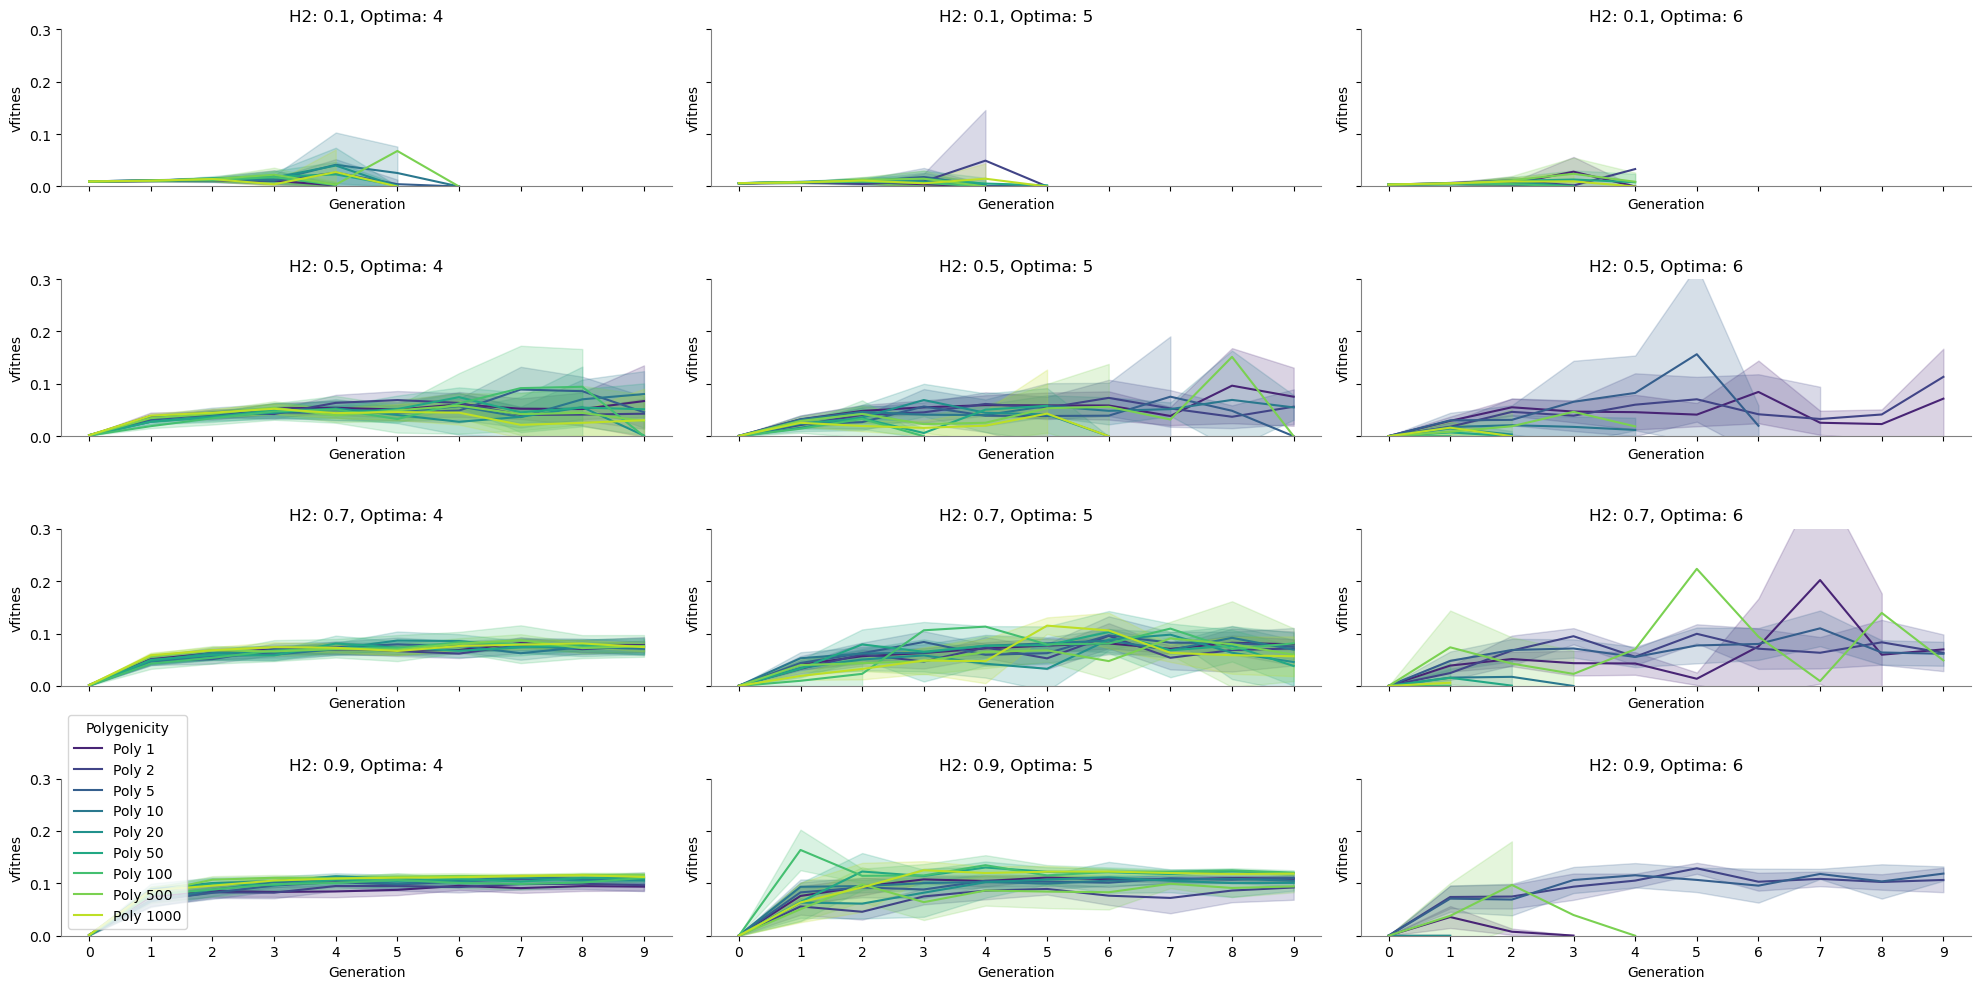

In [43]:
plot_metric('vfitnes',0, 0.3, far_optima, False)

In [33]:
os.listdir(path)

['maxphenotype.csv',
 'mpheno.csv',
 '.ipynb_checkpoints',
 'vfitnes.csv',
 'va_ve.csv',
 'pop_size_early.csv',
 'vpheno.csv',
 'minphenotype.csv',
 'mfitnes.csv']

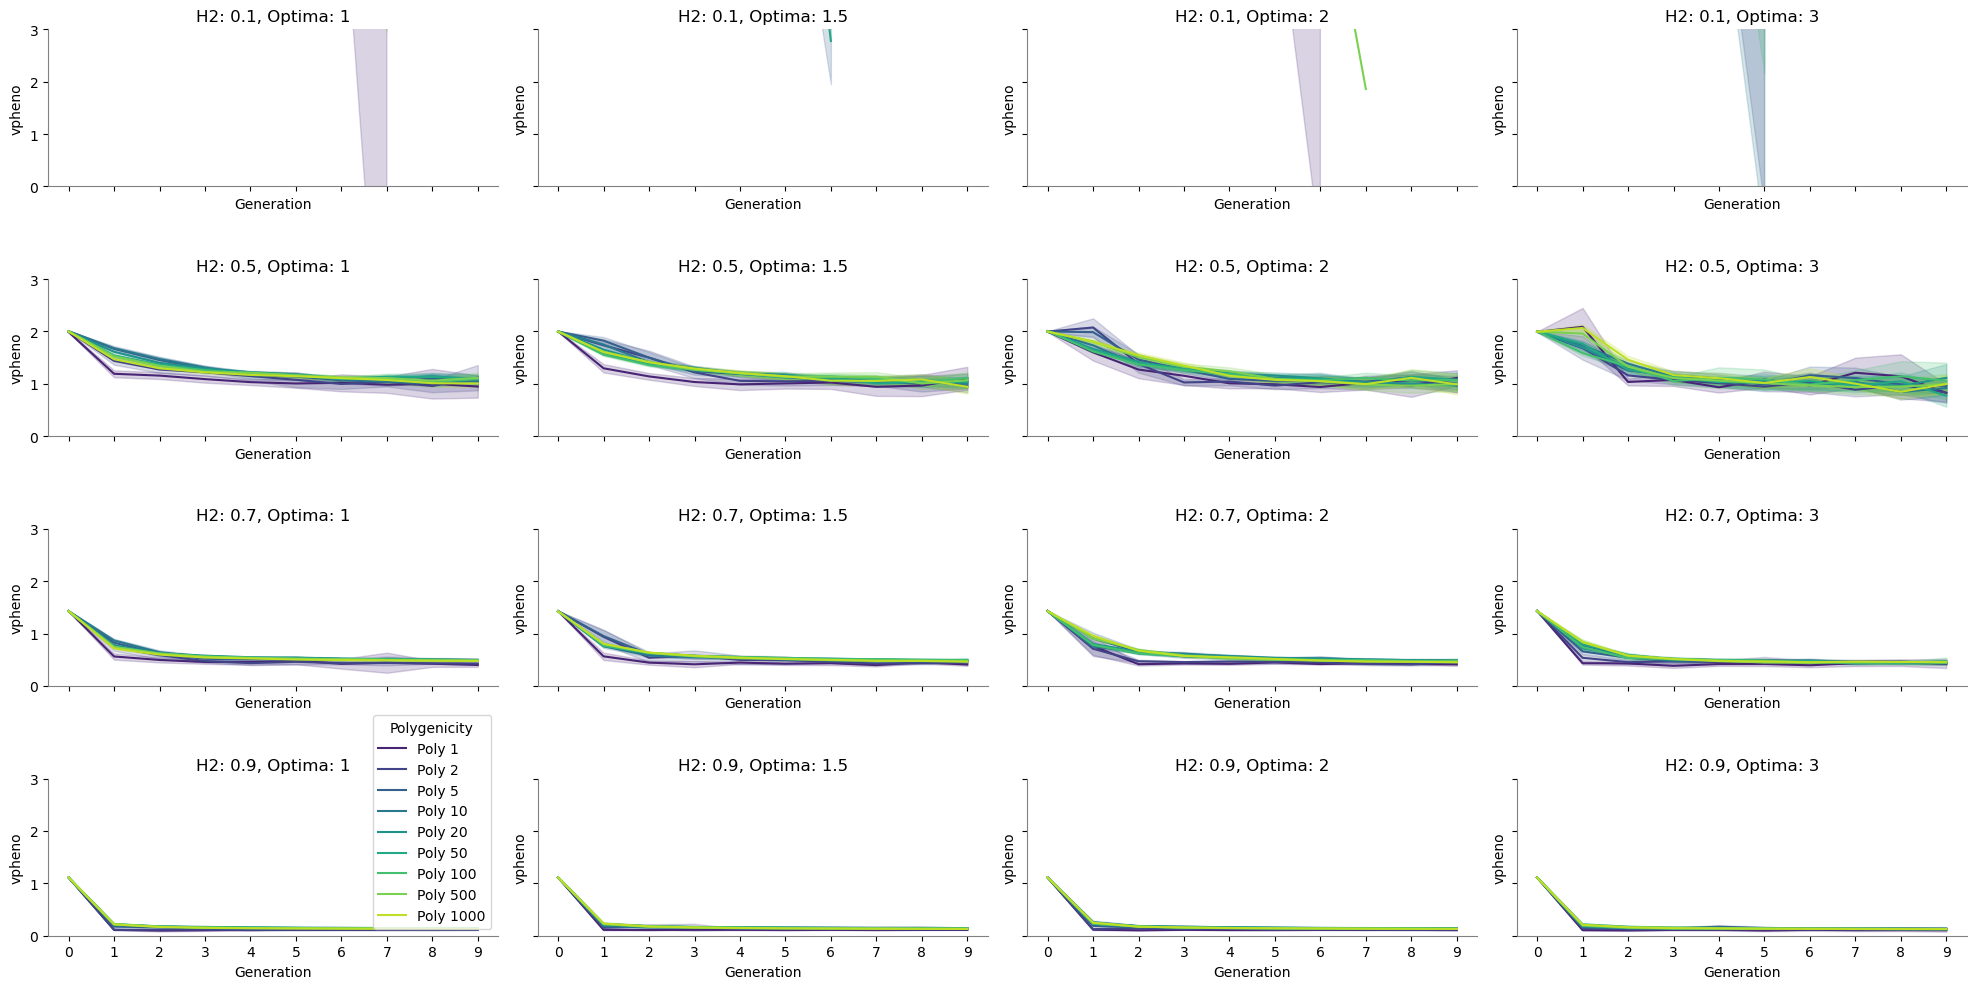

In [47]:
plot_metric('vpheno', 0, 3, close_optima, False)

In [48]:
plot_metric('vpheno', 0, 3, far_optima, False)

In [137]:
def plot_metric_change(df, metric_name):
    change_mean_pheno.loc[:, 'poly'] = change_mean_pheno['poly'].replace(poligenicity_data)

    change_mean_pheno.loc[:, 'h2'] = change_mean_pheno['h2'].replace(heritability_data)

    df = change_mean_pheno.copy()

    h2_levels = sorted(df['h2'].unique())#heritability_data.values()
    optima_levels = sorted(df['optima'].unique())#optima_dict.values()
    poly_levels = sorted(df['poly'].unique())#poligenicity_data.values()

    df = df.fillna(0)

    fig, axs = plt.subplots(len(h2_levels), len(optima_levels), figsize=(20, 10), sharex=True, sharey=True)

    # Handling the 1D array case for axs
    if len(h2_levels) == 1:
        axs = np.array([axs])
    if len(optima_levels) == 1:
        axs = np.array([axs]).T

    for i, h2 in enumerate(h2_levels):
        for j, optima in enumerate(optima_levels):
            ax = axs[i, j] if len(h2_levels) > 1 and len(optima_levels) > 1 else axs[max(i, j)]
            subset_df = df[df['h2'] == h2]

            for poly,color in zip(poly_levels, poly_levels_colors):
                poly_subset = subset_df[(subset_df['optima'] == optima) & (subset_df['poly'] == poly)]
                generations = list(map(str, range(1,10)))

                # Calculate mean and SEM (Standard Error of the Mean) for each generation
                means = poly_subset[generations].mean()
                sems = poly_subset[generations].sem()

                # Calculate the confidence intervals
                ci = 1.96 * sems  # 95% confidence interval, adjust the multiplier as needed for different confidence levels

                # Plotting the mean population size per generation
                ax.plot(generations, means, label=f'Poly {poly}', color = color)

                # Adding the confidence interval as a shaded area
                ax.fill_between(generations, (means - ci), (means + ci), alpha=0.2, color = color)
                # Markers for zero values
                zero_indices = means[means == 0].index
                if not zero_indices.empty:
                    ax.scatter(zero_indices, [0]*len(zero_indices), color=color, zorder=9, alpha=0.5)

            #ax.axhline(0, color='grey', linestyle='-', linewidth=1)
            #ax.axvline(0, color='grey', linestyle='-', linewidth=1)

            #ax.set_ylim(y_lim_min, y_lim_max)  # Adjust 100 to your desired maximum y-value
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_color('grey')
            ax.spines['left'].set_color('grey')
            ax.set_title(f'H2: {h2}, Optima: {optima}')
            ax.set_xlabel('Generation')
            ax.set_ylabel(metric_name)
            if i == len(h2_levels) - 1 and j == 0:
                ax.legend(title='Polygenicity')

    plt.tight_layout()
    return plt.show()

In [141]:
mpheno = pd.read_csv(path + 'mpheno_stsc' + '.csv',  index_col=[0])

mpheno = mpheno.reset_index()

mpheno = get_params(mpheno)


change_mean_pheno = pd.DataFrame()
# Iterate through the columns and calculate differences
for i in range(1, 10):
    col_name = str(i)  # Create a new column name
    change_mean_pheno[col_name] = mpheno.loc[:, str(i)] - mpheno.loc[:, str(i-1)]

change_mean_pheno = pd.concat([change_mean_pheno, mpheno[['optima', 'sel', 'h2','poly', 'rep']]],axis=1)

metric_name = 'change_mean_pheno'

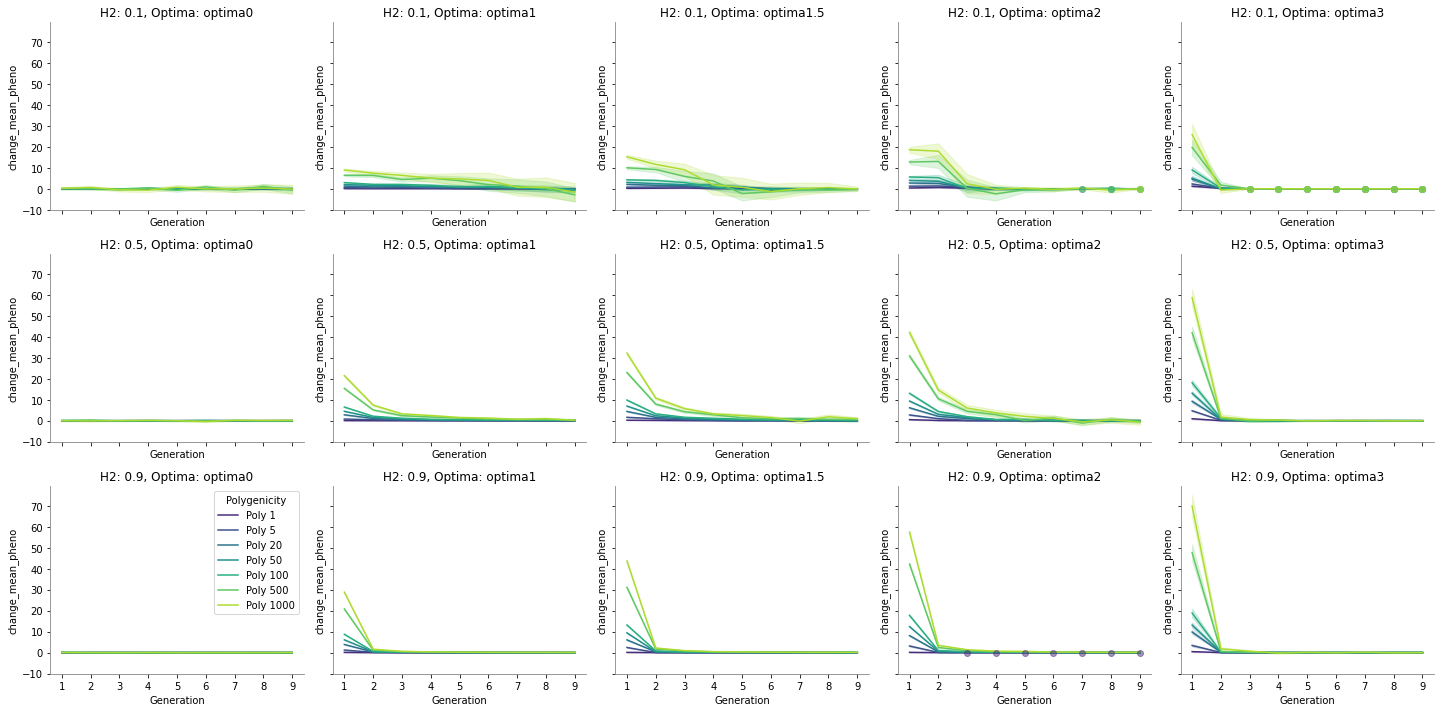

In [143]:
plot_metric_change(change_mean_pheno, metric_name)

In [144]:
mpheno = pd.read_csv(path + 'mpheno_minmaxscaling' + '.csv',  index_col=[0])

mpheno = mpheno.reset_index()

mpheno = get_params(mpheno)


change_mean_pheno = pd.DataFrame()
# Iterate through the columns and calculate differences
for i in range(1, 10):
    col_name = str(i)  # Create a new column name
    change_mean_pheno[col_name] = mpheno.loc[:, str(i)] - mpheno.loc[:, str(i-1)]

change_mean_pheno = pd.concat([change_mean_pheno, mpheno[['optima', 'sel', 'h2','poly', 'rep']]],axis=1)

metric_name = 'change_mean_pheno'

In [145]:
plot_metric_change(change_mean_pheno, metric_name)